## Table of Contents
1. [Data Preparation](#section1)
2. [Default Random Forest Model](#section2)
3. [Random Forest with Cross-Validated Grid Search](#section3)
4. [Random Forest with Best Parameters and Reduced Features](#section4)

### Data Preparation  <a id='section1'></a>

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Defining functions we will use later
def plot_roc_curve(test, model_probs, naive_probs):
    fpr, tpr, _ = roc_curve(test, naive_probs)
    plt.plot(fpr, tpr, linestyle = '--', label = 'Baseline')
    fpr, tpr, _ = roc_curve(test, model_probs)
    plt.plot(fpr, tpr, marker = '.', label = 'Random Forest', markersize = 0.1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC Curve')
    plt.show()
    
def plot_pr_curve(test, model_probs):
    no_skill = len(test[test == 1]) / len(test)
    
    plt.plot( [no_skill, no_skill], linestyle = '--', label = 'Baseline')
    
    precision, recall, _ = precision_recall_curve(test, model_probs)
    plt.plot(recall, precision, marker = '.', label = 'Random Forest', markersize = 0.1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision - Recall Curve')
    plt.legend()
    plt.show()

#### Setting Up Data

In [4]:
#Read in dataframe with cleaned loan data
df = pd.read_csv('./data/loan_all.csv')

In [6]:
#Setting up X and y
X = pd.get_dummies(df.drop(columns = ['loan_status']))
y = df['loan_status']

In [7]:
#Train, test, split with stratify, scaled
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    stratify = y,
                                                    test_size= 0.2)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [8]:
#Baseline Model
dummy_model = DummyClassifier(strategy= 'stratified')
dummy_model.fit(X_train, y_train)
naive_preds = dummy_model.predict_proba(X_test)[:,1]


In [ ]:
recall_score(y_test, naive

### Default Random Forest Model <a id='section2'></a>

In [37]:
#Instantiation and Fit
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

In [39]:
#Accuracy Scores
print(cross_val_score(rf, X_train, y_train, cv = 5).mean())
print(cross_val_score(rf, X_test, y_test, cv = 5).mean())

0.9064292813806232

In [62]:
#Setting up predicted probabilities
y_hat = rf.predict_proba(X_test)
rf_model_probs = y_hat[:,1]

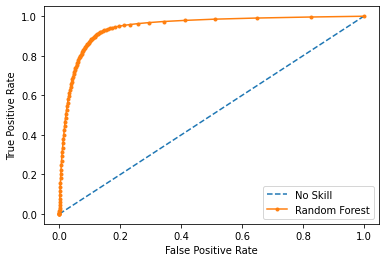

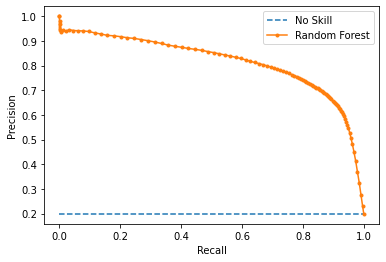

ROC-AUC score no skill: 0.500
ROC-AUC score random forest: 0.946
PR-AUC score no skill: 0.278
PR-AUC score random forest: 0.815


In [120]:
#Plotting relevant curves and scores
plot_roc_curve(y_test, rf_model_probs, naive_preds)
plot_pr_curve(y_test, rf_model_probs)

print(f'ROC-AUC score no skill: {roc_auc_score(y_test, naive_preds):.3f}')
print(f'ROC-AUC score random forest: {roc_auc_score(y_test, rf_model_probs):.3f}')

precision, recall, _ = precision_recall_curve(y_test, naive_preds)
print(f'PR-AUC score no skill: {auc(recall, precision):.3f}')
precision, recall, _ = precision_recall_curve(y_test, rf_model_probs)

print(f'PR-AUC score random forest: {auc(recall, precision):.3f}')

In [57]:
#Creating dataframe with important features
important_features = pd.DataFrame({'importance': rf.feature_importances_}, index = X_train.columns).sort_values(by = 'importance', ascending = False)

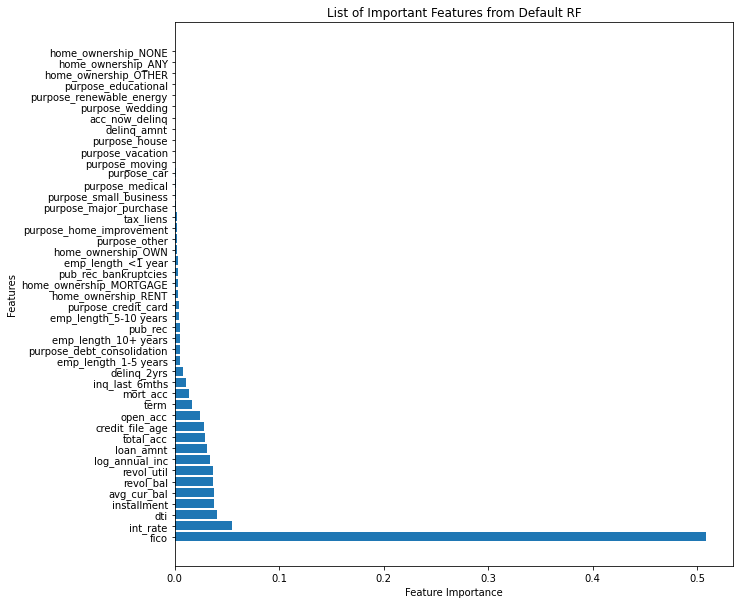

In [124]:
#Horizontal Bar Chart with important features
plt.figure(figsize = (10,10))
plt.barh(important_features.index, important_features.importance)
plt.title('List of Important Features from Default RF');
plt.xlabel('Feature Importance')
plt.ylabel('Features');

With our initial Random Forest model using default parameters, our accuracy score for both the training set and testing set performed better than the accuracy score. When looking at the feature importances, we can see that the top 5 features in importance are FICO, Interest Rate, Debt-to-Income ratio, average current balance, and revolving balance. We also see that a lot of the one-hot encoded variables show very little importance, specifically the values for home ownership that are low ('NONE', 'ANY', 'OTHER'), and the values for loan purpose that are also low. We may consider either removing these observations or grouping them into a category that almagamates them all. We also see that 'delinq_amt' and 'acc_now_delinq' also score very low in feature importance so we may drop these features for the other models. 

For now, we will utilize GridSearchCV to find the optimal parameters for our random forest model and see if we come out with the same feature importances. We will then run a model with a reduced set of features which we will regard as RF + RF.

### Random Forest with GridSearchCV <a id='section3'></a>

#### Random Forest with Grid Search for Parameter Tuning

In [9]:

rf = RandomForestClassifier()

rf_param_grid = {
    'n_estimators' : [50, 100, 250],
    'max_features' : ['auto', 2, 10],
    'max_depth'    : [None, 1, 3, 5, 20],
    'bootstrap'    : [True, False]
}

rf_gs = GridSearchCV(rf, param_grid=rf_param_grid, cv = 3, verbose = 2)

rf_gs.fit(X_train, y_train)
print(rf_gs.best_score_)


Wall time: 0 ns
Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=50; total time= 1.6min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=50; total time= 1.5min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=50; total time= 1.6min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=100; total time= 3.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=100; total time= 3.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=100; total time= 3.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=250; total time= 7.8min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=250; total time= 7.8min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=250; total time= 8.6min
[CV] END bootstrap=True, max_depth=None, max_feature

AttributeError: 'GridSearchCV' object has no attribute 'best_params'

In [11]:
#Training Accuracy Score
rf_gs.score(X_train, y_train)

0.9601850308068904

In [ ]:
#Testing Accuracy Score
rf_gs.score(X_test, y_test)

0.9067949466089685

In [23]:
#Best Parameters
rf_gs.best_params_

{'bootstrap': True, 'max_depth': 20, 'max_features': 10, 'n_estimators': 250}

In [20]:
#Setting up our predicted probabilities
gs_y_hat = rf_gs.predict_proba(X_test)
gs_train_preds = rf_gs.predict_proba(X_train)

gs_model_probs = gs_y_hat[:,1]
gs_model_train_probs = gs_train_preds[:,1]

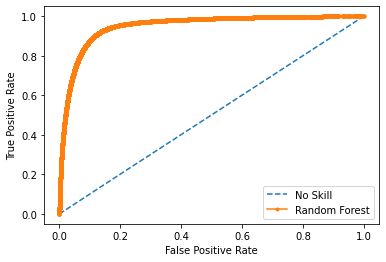

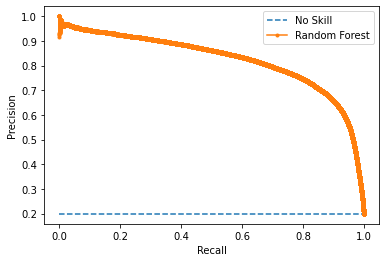

Training Data ROC-AUC score random forest (GridSearch CV): 0.992
Testing Data ROC-AUC score random forest (GridSearch CV): 0.950
Training Data PR-AUC score random forest (GridSearch CV): 0.971
Testing Data PR-AUC score random forest (GridSearch CV): 0.824


In [22]:
#Plotting relevant curves and scores
plot_roc_curve(y_test, gs_model_probs, naive_preds)
plot_pr_curve(y_test, gs_model_probs)

print(f'Training Data ROC-AUC score random forest (GridSearch CV): {roc_auc_score(y_train, gs_model_train_probs):.3f}')
print(f'Testing Data ROC-AUC score random forest (GridSearch CV): {roc_auc_score(y_test, gs_model_probs):.3f}')

precision, recall, _ = precision_recall_curve(y_train, gs_model_train_probs)
print(f'Training Data PR-AUC score random forest (GridSearch CV): {auc(recall, precision):.3f}')

precision, recall, _ = precision_recall_curve(y_test, gs_model_probs)
print(f'Testing Data PR-AUC score random forest (GridSearch CV): {auc(recall, precision):.3f}')

### Random Forest with Feature Selection and Best Parameters <a id='section4'></a>

In [9]:
#Dropping irrelevant features
df.drop(columns = ['acc_now_delinq', 'delinq_amnt'], inplace = True)

In [10]:
#Exporting to use for other models
df.to_csv('./data/loan_rf_features.csv', index = False)

In [11]:
#Setting up X and y again since we removed features
X = pd.get_dummies(df.drop(columns = ['loan_status']))
y = df['loan_status']

In [12]:
#Train, test, split with scaling
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    stratify = y,
                                                    test_size= 0.2)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [13]:
#Instantiating model with best params, fitting
rf_best = RandomForestClassifier(max_depth = 20,
                                 max_features = 10,
                                 n_estimators = 250,
                                 bootstrap = True,
                                 n_jobs= -1)

rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=10, n_estimators=250,
                       n_jobs=-1)

In [14]:
print(rf_best.score(X_train, y_train))
print(rf_best.score(X_test, y_test))

0.9588568862683875
0.9066509537631393


In [14]:
#setting up our best random forest model probabilities
best_rf_train_probs = rf_best.predict_proba(X_train)[:,1]
best_rf_test_probs = rf_best.predict_proba(X_test)[:,1]

best_rf_train_preds = rf_best.predict(X_train)
best_rf_test_preds = rf_best.predict(X_test)

In [15]:
#Exporting for evaluation
rf_probs = pd.DataFrame(best_rf_test_probs, columns = ['rf_probs'])
rf_probs.to_csv('./rf_probs.csv')

In [16]:
recall_score(y_test, best_rf_test_preds)

0.7451420675360566

In [17]:
precision_score(y_test, best_rf_test_preds)

0.7488283284152057

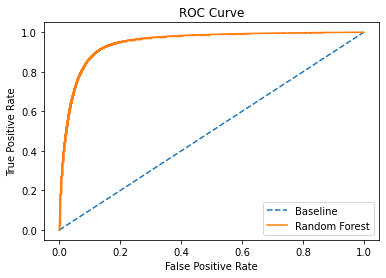

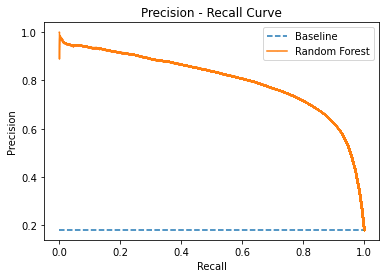

Training Data ROC-AUC score random forest (Best Parameters + Feature Selection): 0.992
Testing Data ROC-AUC score random forest (Best Parameters + Feature Selection): 0.949
Training Data PR-AUC score random forest (GridSearch CV): 0.969
Testing Data PR-AUC score random forest (GridSearch CV): 0.804


In [18]:
#Plotting relevant curves and scores
plot_roc_curve(y_test, best_rf_test_probs, naive_preds)
plot_pr_curve(y_test, best_rf_test_probs)

print(f'Training Data ROC-AUC score random forest (Best Parameters + Feature Selection): {roc_auc_score(y_train, best_rf_train_probs):.3f}')
print(f'Testing Data ROC-AUC score random forest (Best Parameters + Feature Selection): {roc_auc_score(y_test, best_rf_test_probs):.3f}')

precision, recall, _ = precision_recall_curve(y_train, best_rf_train_probs)
print(f'Training Data PR-AUC score random forest (GridSearch CV): {auc(recall, precision):.3f}')
precision, recall, _ = precision_recall_curve(y_test, best_rf_test_probs)
print(f'Testing Data PR-AUC score random forest (GridSearch CV): {auc(recall, precision):.3f}')

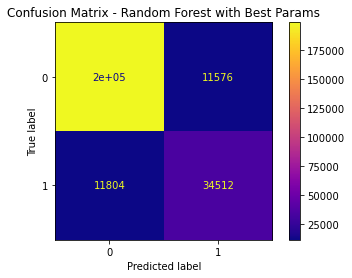

In [19]:
#Confusion Matrix
cm = confusion_matrix(y_test, best_rf_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= rf_best.classes_)
disp.plot(cmap = 'plasma')
plt.title('Confusion Matrix - Random Forest with Best Params');

In [2]:
#Important features with importance > 0.0025
important_features = pd.DataFrame({'importance': rf_best.feature_importances_}, index = X.columns).sort_values(by = 'importance', ascending = False)
important_features = important_features[important_features['importance'] > 0.0025]

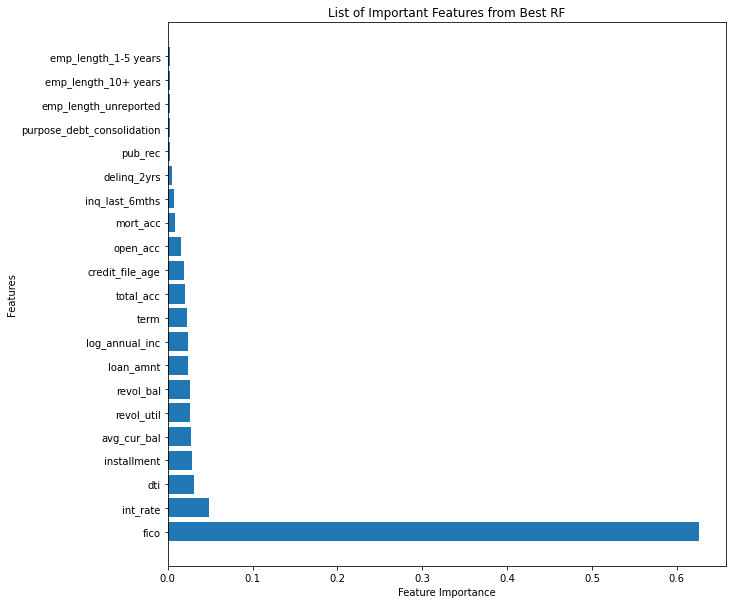

In [21]:
#Horizontal bar chart of important features
plt.figure(figsize = (10,10))
plt.barh(important_features.index, important_features.importance)
plt.title('List of Important Features from Best RF');
plt.xlabel('Feature Importance')
plt.ylabel('Features');